In [1]:
import pandas as pd

Loading dataset

In [2]:
df_train = pd.read_feather("../../../data/processed/CLTP_train_set.feather")

In [3]:
X_train = df_train.drop(["CLTP"], axis=1)
y_train = df_train["CLTP"]
del df_train

## Training

In [4]:
from sklearn.utils.class_weight import compute_class_weight 

In [5]:
weights = compute_class_weight("balanced", sorted(y_train.unique()), y_train)
comp_weights = { c: weights[c] for c in sorted(y_train.unique()) }
comp_weights

{0: 0.16605439075282444,
 1: 4.843155260581003,
 2: 5.353106991331788,
 3: 5.71981619876849,
 4: 6.868128544890112,
 5: 7.2886583420934565,
 6: 7.876366004190023}

Dummify 

In [6]:
X_train = X_train.drop(["DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)

In [7]:
X_train = pd.get_dummies(X_train)

In [8]:
X_train = X_train.fillna(-999)

### Optimization dataset

In [9]:
df_opt = pd.read_feather("../../../data/processed/CLTP_optimization_set.feather")

In [10]:
X_opt = df_opt.drop(["CLTP"], axis=1)
y_opt = df_opt["CLTP"]
del df_opt
X_opt = X_opt.drop(["DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)
X_opt = pd.get_dummies(X_opt)
X_opt = X_opt.fillna(-999)
for col in [col for col in X_train.columns if col not in X_opt.columns]:
    X_opt[col] = -999
X_opt = X_opt.drop([col for col in X_opt.columns if col not in X_train.columns], axis=1)

### Hyperopt config

In [1]:
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.metrics import f1_score 
from numpy.random import RandomState
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm_notebook as tqdm

In [12]:
lgbm_dict = {
    'boosting_type': hp.choice('b_type', ['gbdt', 'dart', 'goss']),
    'max_depth': hp.choice('max_depth', range(5, 20, 5)),
    'n_estimators': hp.choice('estimators', [20, 50, 100, 200]),
    'n_jobs': -1,
    'random_state': 42,
    'learning_rate': hp.choice('learning_rate', [1e-3, 1e-2, 1e-1, 0.5, 1.]),
    'class_weight' :  'balanced',
    'subsample': 0.5
}
rf_dict = {
    'n_estimators': hp.choice('estimators', [200, 500]),
    'max_features': hp.choice('max_features',['auto', 'sqrt', 'log2']),
    'max_depth' : hp.choice('max_depth', [4, 5, 6, 7, 8]),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'class_weight':  'balanced',
}

In [2]:
evals = 10
pbar = tqdm(total=evals*2)

def __optimizerFunc(args):
    pbar.update(1)
    model = RandomForestClassifier(**args)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_opt)
    score = f1_score(y_opt, y_pred, average='micro')

    # greater is better
    score = 1-score

    pbar.update(1)

    return {
            "loss": score,
            "status": STATUS_OK,
           }

print("\nOptimizing...\n")
trials = Trials()
__bestClassifier = fmin(fn=__optimizerFunc,
                        space=rf_dict,
                        algo=tpe.suggest,
                        max_evals=evals,
                        trials=trials,
                        rstate=RandomState(42)
                        )
pbar.close()

print("{}\n".format(trials.results))



Optimizing...



NameError: name 'rf_dict' is not defined

In [14]:
opt_model = RandomForestClassifier(**space_eval(rf_dict, __bestClassifier))

In [16]:
opt_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Dump training columns

In [17]:
cols = list(X_train.columns)

In [18]:
import pickle
with open('../../../src/models/Training columns - CLTP - one vs. rest - dummies.md', 'wb') as file:
    pickle.dump(cols, file, pickle.HIGHEST_PROTOCOL)

### Feature importance

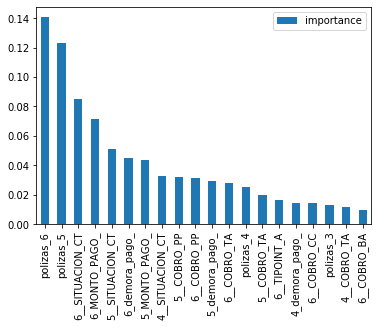

In [28]:
fi = pd.DataFrame(opt_model.feature_importances_,index=X_train.columns, columns=['importance']
                                   ).sort_values('importance', ascending=False)
fi.iloc[0:20].plot.bar()

In [36]:
fi[fi["importance"] > 0].count() / fi.count()

importance    0.509804
dtype: float64

### Validation Dataset

In [20]:
df_val = pd.read_feather("../../../data/processed/CLTP_validation_set.feather")

In [21]:
X_val = df_val.drop(["CLTP"], axis=1)
y_val = df_val["CLTP"]
del df_val

In [22]:
X_val = X_val.drop(["DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)
X_val = pd.get_dummies(X_val)
X_val = X_val.fillna(-999)

In [23]:
for col in [col for col in X_train.columns if col not in X_val.columns]:
    X_val[col] = -999

In [24]:
X_val = X_val.drop([col for col in X_val.columns if col not in X_train.columns], axis=1)

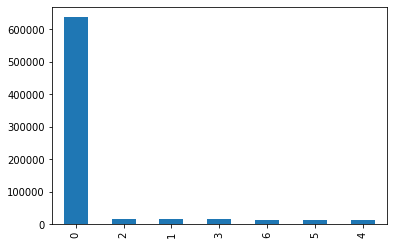

In [25]:
y_val.value_counts().plot.bar()

### Model metrics

In [26]:
from sklearn.metrics import roc_auc_score,confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

In [31]:
predictions = opt_model.predict(X_val)
print('Confusion Matrix')
print(confusion_matrix(y_val, predictions))
print()
print('Metrics')
print(f'Accuracy: {accuracy_score(y_val, predictions)}')
print(f'F1_score: {f1_score(y_val, predictions, average=None)} ')

Confusion Matrix
[[425990   1282   5305  27264  19102 122874  34963]
 [     0  17420     48      0      0      0      0]
 [     1    203  17727     20      0      0      0]
 [   371     22    433  12686    240   1827     98]
 [  5990     55    173   1853   1106   3215    656]
 [  7337     46    187    789    473   3822    974]
 [  7393     39    112    688    470   4111    910]]

Metrics
Accuracy: 0.6586262057601867
F1_score: [0.78605948 0.95360613 0.84543113 0.4302016  0.06422951 0.0511383
 0.03546099] 


In [37]:
import seaborn as sns

In [51]:
cmap = sns.color_palette("coolwarm", 7)

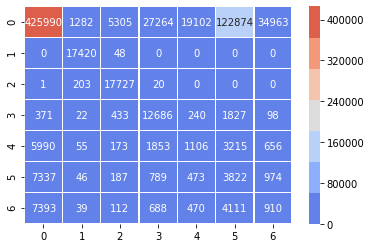

In [52]:
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d", linewidths=.5, cmap=cmap) 

In [53]:
pd.crosstab(y_val, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,All
True,,,,,,,,
0,425990,1282,5305,27264,19102,122874,34963,636780
1,0,17420,48,0,0,0,0,17468
2,1,203,17727,20,0,0,0,17951
3,371,22,433,12686,240,1827,98,15677
4,5990,55,173,1853,1106,3215,656,13048
5,7337,46,187,789,473,3822,974,13628
6,7393,39,112,688,470,4111,910,13723
All,447082,19067,23985,43300,21391,135849,37601,728275
